In [1]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
result_dir='problem_classification_ela_results'
seeds=[200,400,600,800,1000]
visualizations_dir='ela_problem_classification_visualizations'
seed_mapping={index:seed for index,seed in enumerate(seeds)}

In [3]:
os.makedirs(visualizations_dir,exist_ok=True)

In [4]:
all_algorithms=['DE','ES','PSO']
all_stats=['min','max','mean','std']
all_dimensions=[3,5,10,20]

In [5]:
def get_global_file_name(dimension,algorithms, iteration_start,iteration_end, train_on_seed,seed, difference,stat=None, normalize_y=False):
    file_name=f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_1000_{"train" if train_on_seed else "test"}_on_seed_{seed}{"_differenced" if difference else ""}'
    if stat is None:
        return os.path.join(result_dir + f'_normalize_{normalize_y}',file_name)
    else:
        return os.path.join(result_dir+ f'_normalize_{normalize_y}',f'stat_{stat}_' + file_name)


def get_visualization_output_name_without_seed(dimension,algorithms, iteration_start,iteration_end, train_on_seed, difference):
    return os.path.join(visualizations_dir,f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_1000_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}')

In [6]:
def get_seed_accuracies_df(dimension,algorithm, iteration_start, iteration_end, train_on_seed, difference, seeds, normalize_y, stat=None):
    seed_accuracies=[]
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(dimension,algorithm, iteration_start,iteration_end, train_on_seed,train_seed, difference, stat, normalize_y)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, index_col=[0], compression='zip').rename(columns={'seed':'test_seed'}) 
            test_df_fold['fold']=fold
            test_df_fold['train_seed']=train_seed
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])



        for test_seed in seeds:
            for fold in range(0,10):
                seed_preds_df=test_df.query('test_seed==@test_seed and fold==@fold')
                seed_accuracies+=[(accuracy_score(seed_preds_df['y'], seed_preds_df['preds']), train_seed, test_seed, fold)]


    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy','train_seed','test_seed','fold']
        return seed_accuracy_df, test_df_all
    return None

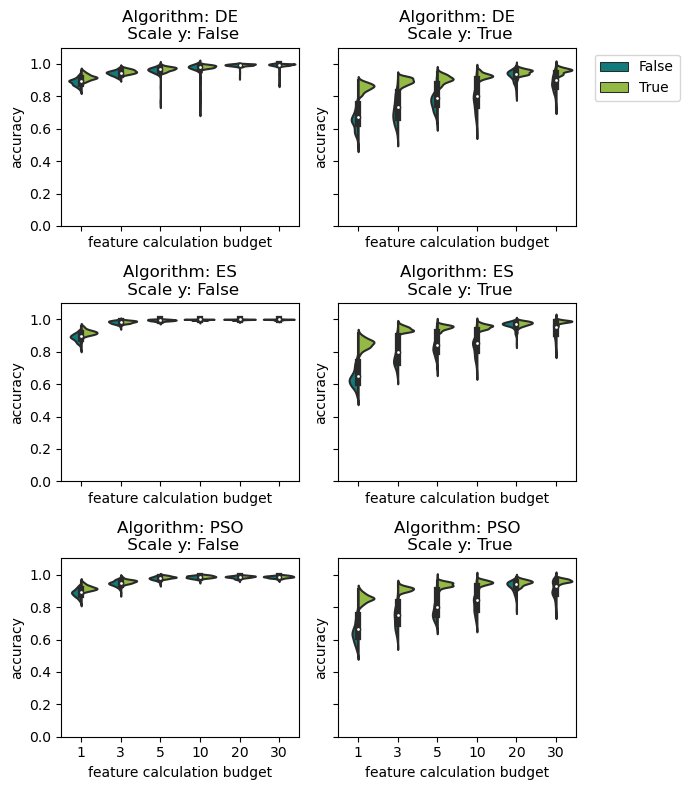

In [10]:
results_per_iteration=[]
all_accuracies=pd.DataFrame()
all_algorithms=['DE','ES','PSO']
for dimension in [5]: #
    all_accuracies=pd.DataFrame()
    for algorithm in all_algorithms:
        for train_on_seed_1 in [True]:
            for difference_1 in [False]:
                for end_iteration in [0,2,4,9,19,29]:
                    for normalize_y in [False, True]:
                        seed_accuracy_df,_ = get_seed_accuracies_df(dimension,algorithm, 0, end_iteration, train_on_seed_1, difference_1, seeds, normalize_y)
                        seed_accuracy_df['feature calculation budget']=end_iteration+1
                        seed_accuracy_df['algorithm']=algorithm
                        seed_accuracy_df['dimension']=dimension
                        seed_accuracy_df['normalize_y']=normalize_y
                        all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])

    
    all_accuracies['Train seed=Test seed']=all_accuracies.apply(lambda row: row['train_seed']==row['test_seed'], axis=1)
    fig, axes = plt.subplots(len(all_algorithms),2, figsize=(7,8), sharex=True, sharey=True)
    for algorithm_index, algorithm in enumerate(all_algorithms):
        for normalize_y_index, normalize_y in enumerate([False, True]):
            algorithm_accuracies=all_accuracies.query('algorithm==@algorithm and @normalize_y==normalize_y')
            ax=axes[algorithm_index][normalize_y_index] if type(axes) is np.ndarray else axes
            ax.set_title(f'Algorithm: {algorithm}\n Scale y: {normalize_y}')
            sns.violinplot(data=algorithm_accuracies, x="feature calculation budget", y="accuracy", hue='Train seed=Test seed', split=True, palette=color_palette[1:3], ax=ax)
            ax.set_ylim(bottom=0, top=1.1)
            if algorithm_index==0 and normalize_y_index==1:
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            else: 
                ax.get_legend().remove()
    plt.tight_layout()
    
    plt.savefig(os.path.join(visualizations_dir,f'dim_{dimension}_accuracies_all_algorithms.pdf'))
    plt.show()